# **라이브러리 설치 및 폰트 설정**

In [1]:
!pip install statsbombpy #축구 경기 데이터셋
!pip install mplsoccer   #축구장 그리기 라이브러리

import warnings
warnings.filterwarnings("ignore", message="credentials were not supplied")

# 단계 1: 폰트 설치
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get -qq -y install fonts-nanum > /dev/null
#fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'



fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

# **패스 네트워크 시각화**

**대한민국 vs 멕시코**

분석 구간: 0 ~ 63분


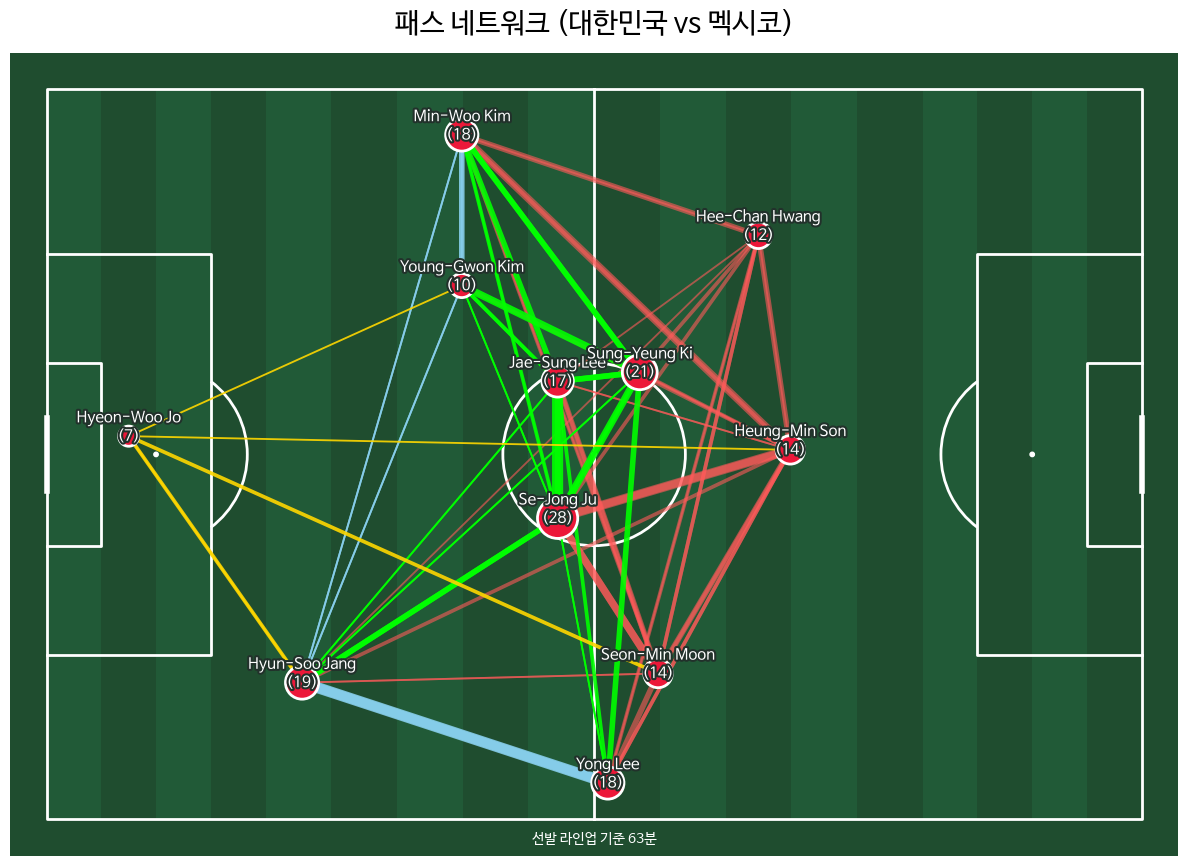

In [7]:
from statsbombpy import sb
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np

# 1. 데이터 로드 (대한민국 vs 멕시코)
match_id = 7553
events = sb.events(match_id=match_id)
team_name = "South Korea"

# [수정] 선수 포지션 매핑 (골키퍼, 수비수, 미드필더 식별용)
lineups = sb.lineups(match_id=match_id)[team_name]
player_positions = {}

for _, row in lineups.iterrows():
    positions = row['positions']
    if not positions: continue

    # 선발 포지션 기준
    pos_name = positions[0]['position']
    player_name = row['player_name']

    if "Goalkeeper" in pos_name:
        player_positions[player_name] = 'GK'
    elif "Back" in pos_name: # Center Back, Right Back, Wing Back 등
        player_positions[player_name] = 'DF'
    elif "Midfield" in pos_name: # [추가] 미드필더 식별
        player_positions[player_name] = 'MF'
    else:
        player_positions[player_name] = 'Other' # 공격수 등

# 2. 데이터 필터링 (선발 유지 시간 & 오픈 플레이)
subs = events[(events["team"] == team_name) & (events["type"] == "Substitution")]
end_minute = subs["minute"].min() if not subs.empty else events["minute"].max()
print(f"분석 구간: 0 ~ {end_minute}분")

passes = events[
    (events["team"] == team_name) &
    (events["type"] == "Pass") &
    (events["minute"] < end_minute) &
    (events["pass_type"].isna())
].copy()

passes["x"] = passes["location"].apply(lambda x: x[0])
passes["y"] = passes["location"].apply(lambda x: x[1])

# 3. 데이터 집계
nodes = passes.groupby('player').agg({'x': 'median', 'y': 'median', 'id': 'count'}).rename(columns={'id': 'count'})

edges = passes.groupby(['player', 'pass_recipient']).size().reset_index(name='pass_count')
edges = edges.merge(nodes, on='player').merge(nodes, left_on='pass_recipient', right_on='player', suffixes=('', '_end'))
edges = edges[edges['pass_count'] >= 1]

# 4. 시각화
pitch = Pitch(pitch_type='statsbomb', pitch_color='#1F4D2F', line_color='white', stripe=True, stripe_color='#215A37')
fig, ax = pitch.draw(figsize=(14, 9))
fig.set_facecolor('white')

# (1) 패스 연결선 그리기
max_width = 8
max_pass = edges['pass_count'].max()

for _, row in edges.iterrows():
    width = (row['pass_count'] / max_pass * max_width)

    p1_pos = player_positions.get(row['player'], 'Other')
    p2_pos = player_positions.get(row['pass_recipient'], 'Other')

    # 색상 로직
    if p1_pos == 'GK' or p2_pos == 'GK':
        line_color = 'gold'       # 1순위: 골키퍼 관여
        alpha_val = 0.9
        z_order = 1.6
    elif (p1_pos == 'MF' and p2_pos == 'MF') or \
         (p1_pos == 'MF' and p2_pos == 'DF') or \
         (p1_pos == 'DF' and p2_pos == 'MF'):
        line_color = 'lime'       # 2순위: 미드필더-미드필더, 미드필더-수비수
        alpha_val = 0.9
        z_order = 1.5
    elif p1_pos == 'DF' and p2_pos == 'DF':
        line_color = 'skyblue'    # 3순위: 수비수 간 패스
        alpha_val = 0.9
        z_order = 1.4
    else:
        line_color = '#FF5A5A'    # 그 외 (공격수 등) - 요청하신 색상
        alpha_val = 0.6
        z_order = 1

    pitch.lines(row['x'], row['y'], row['x_end'], row['y_end'],
                lw=width, color=line_color, zorder=z_order, alpha=alpha_val, ax=ax)

# (2) 선수 위치 점 그리기
# 색상을 더 밝은 빨간색(#FF5A5A)으로 변경
pitch.scatter(nodes['x'], nodes['y'], s=nodes['count'] * 30,
              color="#EC1839", edgecolors='white', linewidth=2, zorder=2, ax=ax)

# (3) 선수 이름 및 횟수 표시
for player, row in nodes.iterrows():
    label_text = f"{player}\n({int(row['count'])})"
    pitch.annotate(label_text, xy=(row['x'], row['y']-1),
                   c='white', va='center', ha='center', size=11, weight='bold', zorder=3, ax=ax,
                   path_effects=[path_effects.withStroke(linewidth=3, foreground="#22312b")])

# 제목 및 범례
ax.set_title("패스 네트워크 (대한민국 vs 멕시코)", fontsize=20, fontweight='bold', pad=15)
plt.figtext(0.5, 0.044, f"선발 라인업 기준 {end_minute}분", ha="center", fontsize=10, color="white")

plt.show()

**대한민국 vs 독일**

분석 구간: 0 ~ 55분


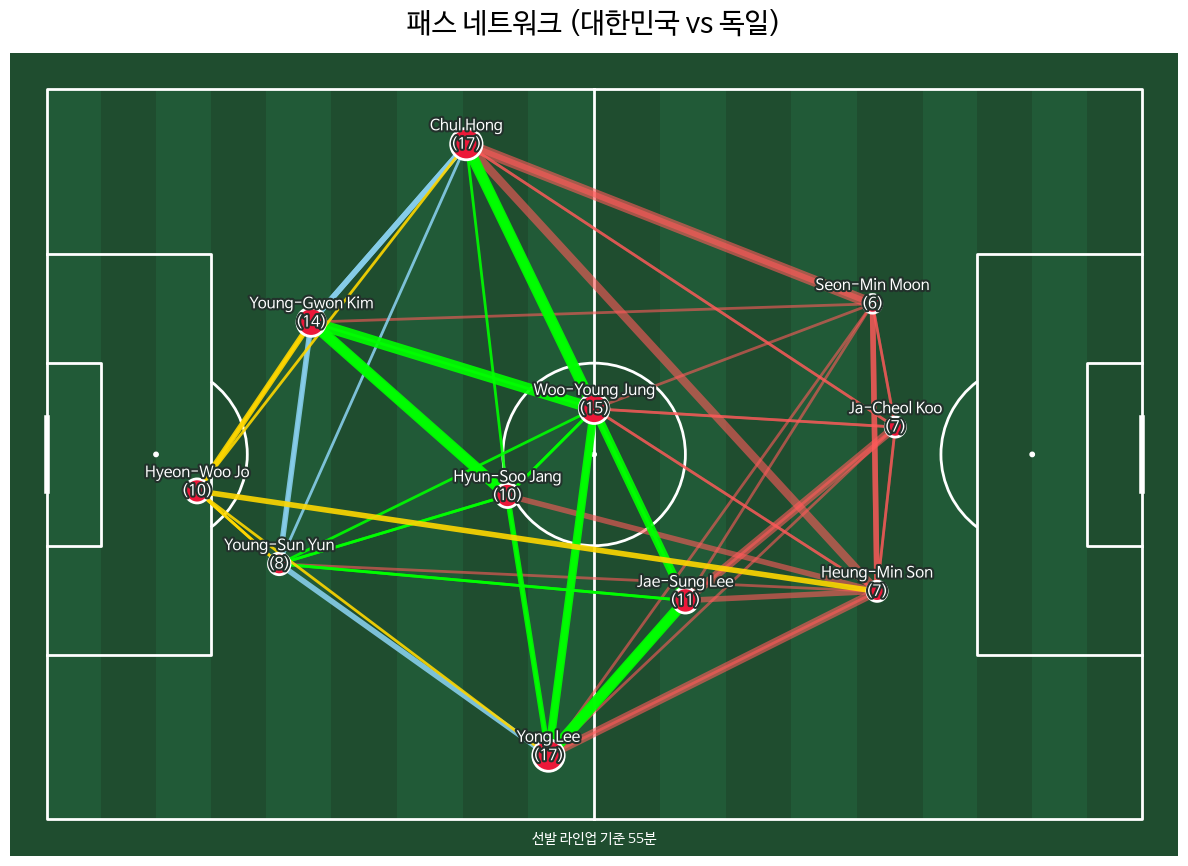

In [14]:
from statsbombpy import sb
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np

# 1. 데이터 로드 (대한민국 vs 독일)
match_id = 7567
events = sb.events(match_id=match_id)
team_name = "South Korea"

# [수정] 선수 포지션 매핑 (중앙 미드필더 오분류 수정)
lineups = sb.lineups(match_id=match_id)[team_name]
player_positions = {}

for _, row in lineups.iterrows():
    positions = row['positions']
    if not positions: continue

    # 선발 포지션 기준
    pos_name = positions[0]['position']
    player_name = row['player_name']

    if "Goalkeeper" in pos_name:
        player_positions[player_name] = 'GK'
    elif "Back" in pos_name: # Center Back, Right Back, Wing Back 등
        player_positions[player_name] = 'DF'
    elif "Midfield" in pos_name:
        # [수정] 로직 개선: 'Center'나 'Defensive'가 포함되면 무조건 미드필더(MF)
        # 예: "Right Center Midfield"는 Right가 있어도 중앙 미드필더로 분류
        if "Center" in pos_name or "Defensive" in pos_name:
            player_positions[player_name] = 'MF'
        # 그 외에 Left/Right가 있으면 측면 미드필더 -> 윙어(FW)로 분류
        elif "Left" in pos_name in pos_name:
            player_positions[player_name] = 'FW'
        else:
            player_positions[player_name] = 'MF'
    else:
        player_positions[player_name] = 'FW' # 그 외(Forward, Striker, Wing)는 공격수

# 2. 데이터 필터링 (선발 유지 시간 & 오픈 플레이)
subs = events[(events["team"] == team_name) & (events["type"] == "Substitution")]
end_minute = subs["minute"].min() if not subs.empty else events["minute"].max()
print(f"분석 구간: 0 ~ {end_minute}분")

passes = events[
    (events["team"] == team_name) &
    (events["type"] == "Pass") &
    (events["minute"] < end_minute) &
    (events["pass_type"].isna())
].copy()

passes["x"] = passes["location"].apply(lambda x: x[0])
passes["y"] = passes["location"].apply(lambda x: x[1])

# 3. 데이터 집계
nodes = passes.groupby('player').agg({'x': 'median', 'y': 'median', 'id': 'count'}).rename(columns={'id': 'count'})

edges = passes.groupby(['player', 'pass_recipient']).size().reset_index(name='pass_count')
edges = edges.merge(nodes, on='player').merge(nodes, left_on='pass_recipient', right_on='player', suffixes=('', '_end'))
edges = edges[edges['pass_count'] >= 1]

# 4. 시각화
pitch = Pitch(pitch_type='statsbomb', pitch_color='#1F4D2F', line_color='white', stripe=True, stripe_color='#215A37')
fig, ax = pitch.draw(figsize=(14, 9))
fig.set_facecolor('white')

# (1) 패스 연결선 그리기
max_width = 8
max_pass = edges['pass_count'].max()

for _, row in edges.iterrows():
    width = (row['pass_count'] / max_pass * max_width)

    p1_pos = player_positions.get(row['player'], 'Other')
    p2_pos = player_positions.get(row['pass_recipient'], 'Other')

    # 색상 로직
    if p1_pos == 'GK' or p2_pos == 'GK':
        line_color = 'gold'       # 1순위: 골키퍼 관여
        alpha_val = 0.9
        z_order = 1.6
    elif (p1_pos == 'MF' and p2_pos == 'MF') or \
         (p1_pos == 'MF' and p2_pos == 'DF') or \
         (p1_pos == 'DF' and p2_pos == 'MF'):
        line_color = 'lime'       # 2순위: 미드필더-미드필더, 미드필더-수비수
        alpha_val = 0.9
        z_order = 1.5
    elif p1_pos == 'DF' and p2_pos == 'DF':
        line_color = 'skyblue'    # 3순위: 수비수 간 패스
        alpha_val = 0.9
        z_order = 1.4
    else:
        line_color = '#FF5A5A'    # 그 외 (공격수 포함) -> 빨간색
        alpha_val = 0.6
        z_order = 1

    pitch.lines(row['x'], row['y'], row['x_end'], row['y_end'],
                lw=width, color=line_color, zorder=z_order, alpha=alpha_val, ax=ax)

# (2) 선수 위치 점 그리기
pitch.scatter(nodes['x'], nodes['y'], s=nodes['count'] * 30,
              color="#EC1839", edgecolors='white', linewidth=2, zorder=2, ax=ax)

# (3) 선수 이름 및 횟수 표시
for player, row in nodes.iterrows():
    label_text = f"{player}\n({int(row['count'])})"
    pitch.annotate(label_text, xy=(row['x'], row['y']-1),
                   c='white', va='center', ha='center', size=11, weight='bold', zorder=3, ax=ax,
                   path_effects=[path_effects.withStroke(linewidth=3, foreground="#22312b")])

# 제목 및 범례
ax.set_title("패스 네트워크 (대한민국 vs 독일)", fontsize=20, fontweight='bold', pad=15)
plt.figtext(0.5, 0.044, f"선발 라인업 기준 {end_minute}분", ha="center", fontsize=10, color="white")

plt.show()

**대한민국 vs  가나**

분석 구간: 0 ~ 45분


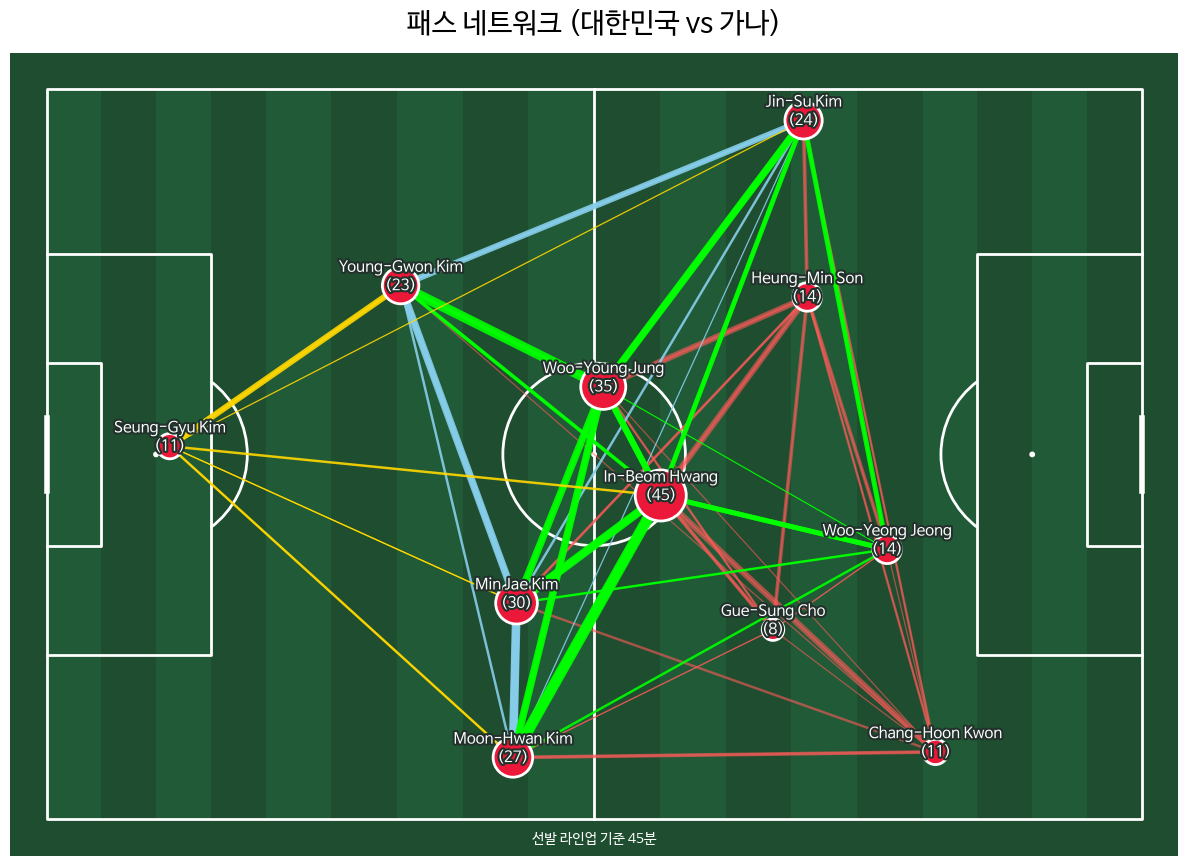

In [20]:
from statsbombpy import sb
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np

# 1. 데이터 로드 (대한민국 vs 가나)
match_id = 3857299
events = sb.events(match_id=match_id)
team_name = "South Korea"

# [수정] 선수 포지션 매핑 (중앙 미드필더 오분류 수정)
lineups = sb.lineups(match_id=match_id)[team_name]
player_positions = {}

for _, row in lineups.iterrows():
    positions = row['positions']
    if not positions: continue

    pos_name = positions[0]['position']
    player_name = row['player_name']

    if "Goalkeeper" in pos_name:
        player_positions[player_name] = 'GK'
    elif "Back" in pos_name:
        player_positions[player_name] = 'DF'
    elif "Midfield" in pos_name:
        if "Center" in pos_name or "Defensive" in pos_name:
            player_positions[player_name] = 'MF'
        elif "Left" in pos_name or "Right" in pos_name:
            player_positions[player_name] = 'FW'
        else:
            player_positions[player_name] = 'MF'
    else:
        player_positions[player_name] = 'FW'

# 2. 데이터 필터링 (선발 유지 시간 & 오픈 플레이)
subs = events[(events["team"] == team_name) & (events["type"] == "Substitution")]
end_minute = subs["minute"].min() if not subs.empty else events["minute"].max()
print(f"분석 구간: 0 ~ {end_minute}분")

# (1) 패스 데이터 추출
passes = events[
    (events["team"] == team_name) &
    (events["type"] == "Pass") &
    (events["minute"] < end_minute) &
    (events["pass_type"].isna())
].copy()
passes["x"] = passes["location"].apply(lambda x: x[0])
passes["y"] = passes["location"].apply(lambda x: x[1])

# (2) [추가] 슈팅 데이터 추출 (공격수 위치 보정용)
shots = events[
    (events["team"] == team_name) &
    (events["type"] == "Shot") &
    (events["minute"] < end_minute)
].copy()
shots["x"] = shots["location"].apply(lambda x: x[0])
passes["y"] = passes["location"].apply(lambda x: x[1])
shots["y"] = shots["location"].apply(lambda x: x[1])

# 3. 데이터 집계
# (1) [수정] 노드 위치 계산 (패스 + 슈팅 데이터 결합)
# 패스와 슈팅 데이터를 합쳐서(concat) 중앙값(median)을 계산합니다.
location_data = pd.concat([
    passes[['player', 'x', 'y']],
    shots[['player', 'x', 'y']]
])
nodes = location_data.groupby('player').agg({'x': 'median', 'y': 'median'})

# 패스 횟수(count)는 기존대로 패스 데이터에서만 집계하여 합칩니다.
pass_counts = passes.groupby('player').size().rename('count')
nodes = nodes.merge(pass_counts, left_index=True, right_index=True)

# (2) 엣지 계산
edges = passes.groupby(['player', 'pass_recipient']).size().reset_index(name='pass_count')
edges = edges.merge(nodes, on='player').merge(nodes, left_on='pass_recipient', right_on='player', suffixes=('', '_end'))
edges = edges[edges['pass_count'] >= 1]

# 4. 시각화
pitch = Pitch(pitch_type='statsbomb', pitch_color='#1F4D2F', line_color='white', stripe=True, stripe_color='#215A37')
fig, ax = pitch.draw(figsize=(14, 9))
fig.set_facecolor('white')

# (1) 패스 연결선 그리기
max_width = 8
max_pass = edges['pass_count'].max()

for _, row in edges.iterrows():
    width = (row['pass_count'] / max_pass * max_width)

    p1_pos = player_positions.get(row['player'], 'Other')
    p2_pos = player_positions.get(row['pass_recipient'], 'Other')

    if p1_pos == 'GK' or p2_pos == 'GK':
        line_color = 'gold'
        alpha_val = 0.9
        z_order = 1.6
    elif (p1_pos == 'MF' and p2_pos == 'MF') or \
         (p1_pos == 'MF' and p2_pos == 'DF') or \
         (p1_pos == 'DF' and p2_pos == 'MF'):
        line_color = 'lime'
        alpha_val = 0.9
        z_order = 1.5
    elif p1_pos == 'DF' and p2_pos == 'DF':
        line_color = 'skyblue'
        alpha_val = 0.9
        z_order = 1.4
    else:
        line_color = '#FF5A5A'
        alpha_val = 0.6
        z_order = 1

    pitch.lines(row['x'], row['y'], row['x_end'], row['y_end'],
                lw=width, color=line_color, zorder=z_order, alpha=alpha_val, ax=ax)

# (2) 선수 위치 점 그리기
pitch.scatter(nodes['x'], nodes['y'], s=nodes['count'] * 30,
              color="#EC1839", edgecolors='white', linewidth=2, zorder=2, ax=ax)

# (3) 선수 이름 및 횟수 표시
for player, row in nodes.iterrows():
    label_text = f"{player}\n({int(row['count'])})"
    pitch.annotate(label_text, xy=(row['x'], row['y']-1),
                   c='white', va='center', ha='center', size=11, weight='bold', zorder=3, ax=ax,
                   path_effects=[path_effects.withStroke(linewidth=3, foreground="#22312b")])

# 제목 및 범례
ax.set_title("패스 네트워크 (대한민국 vs 가나)", fontsize=20, fontweight='bold', pad=15)
plt.figtext(0.5, 0.044, f"선발 라인업 기준 {end_minute}분", ha="center", fontsize=10, color="white")

plt.show()

**대한민국 vs 포르투갈**

분석 구간: 0 ~ 65분


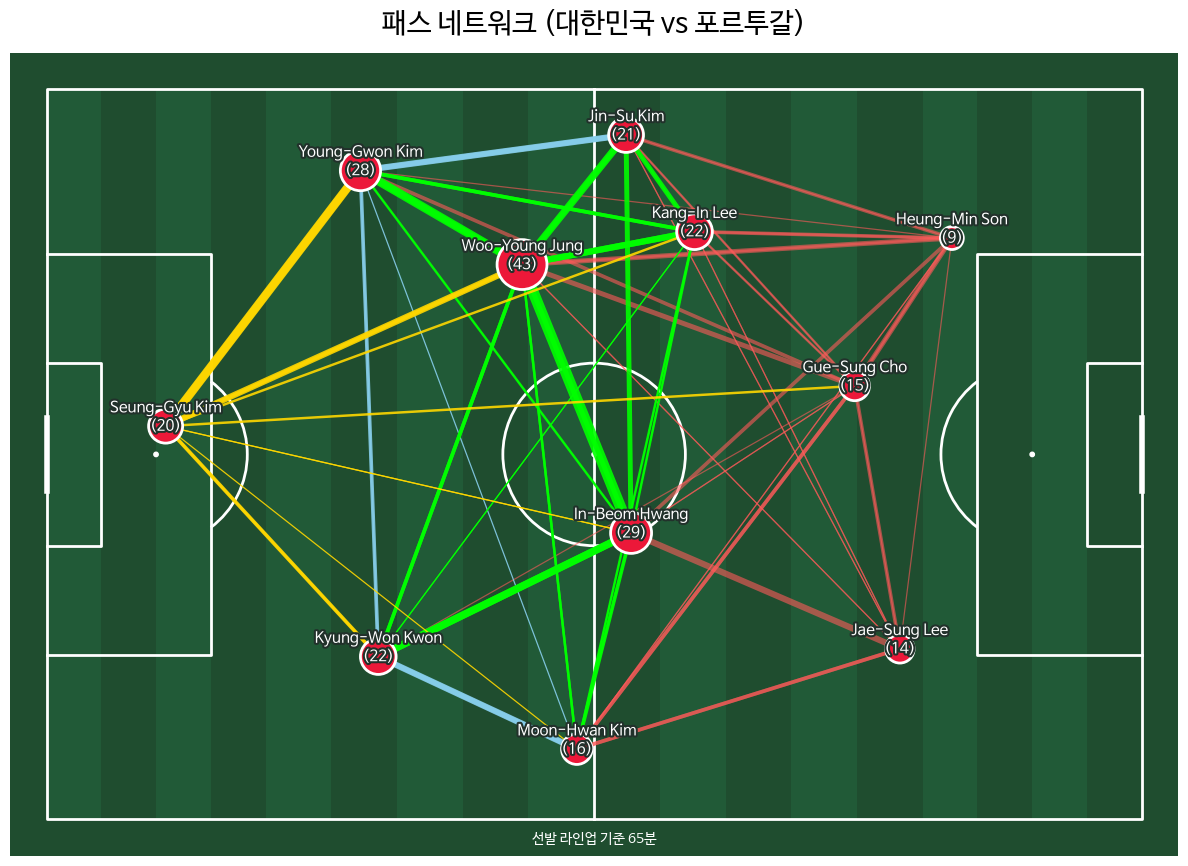

In [22]:
from statsbombpy import sb
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np

# 1. 데이터 로드 (대한민국 vs 포르투갈)
match_id = 3857262
events = sb.events(match_id=match_id)
team_name = "South Korea"

# [수정] 선수 포지션 매핑 (중앙 미드필더 오분류 수정)
lineups = sb.lineups(match_id=match_id)[team_name]
player_positions = {}

for _, row in lineups.iterrows():
    positions = row['positions']
    if not positions: continue

    pos_name = positions[0]['position']
    player_name = row['player_name']

    if "Goalkeeper" in pos_name:
        player_positions[player_name] = 'GK'
    elif "Back" in pos_name:
        player_positions[player_name] = 'DF'
    elif "Midfield" in pos_name:
        if "Center" in pos_name or "Defensive" in pos_name:
            player_positions[player_name] = 'MF'
        elif "Left" in pos_name or "Right" in pos_name:
            player_positions[player_name] = 'FW'
        else:
            player_positions[player_name] = 'MF'
    else:
        player_positions[player_name] = 'FW'

# 2. 데이터 필터링 (선발 유지 시간 & 오픈 플레이)
subs = events[(events["team"] == team_name) & (events["type"] == "Substitution")]
end_minute = subs["minute"].min() if not subs.empty else events["minute"].max()
print(f"분석 구간: 0 ~ {end_minute}분")

# (1) 패스 데이터 추출
passes = events[
    (events["team"] == team_name) &
    (events["type"] == "Pass") &
    (events["minute"] < end_minute) &
    (events["pass_type"].isna())
].copy()
passes["x"] = passes["location"].apply(lambda x: x[0])
passes["y"] = passes["location"].apply(lambda x: x[1])

# (2) [추가] 슈팅 데이터 추출 (공격수 위치 보정용)
shots = events[
    (events["team"] == team_name) &
    (events["type"] == "Shot") &
    (events["minute"] < end_minute)
].copy()
shots["x"] = shots["location"].apply(lambda x: x[0])
passes["y"] = passes["location"].apply(lambda x: x[1])
shots["y"] = shots["location"].apply(lambda x: x[1])

# 3. 데이터 집계
# (1) [수정] 노드 위치 계산 (패스 + 슈팅 데이터 결합)
# 패스와 슈팅 데이터를 합쳐서(concat) 중앙값(median)을 계산합니다.
location_data = pd.concat([
    passes[['player', 'x', 'y']],
    shots[['player', 'x', 'y']]
])
nodes = location_data.groupby('player').agg({'x': 'median', 'y': 'median'})

# 패스 횟수(count)는 기존대로 패스 데이터에서만 집계하여 합칩니다.
pass_counts = passes.groupby('player').size().rename('count')
nodes = nodes.merge(pass_counts, left_index=True, right_index=True)

# (2) 엣지 계산
edges = passes.groupby(['player', 'pass_recipient']).size().reset_index(name='pass_count')
edges = edges.merge(nodes, on='player').merge(nodes, left_on='pass_recipient', right_on='player', suffixes=('', '_end'))
edges = edges[edges['pass_count'] >= 1]

# 4. 시각화
pitch = Pitch(pitch_type='statsbomb', pitch_color='#1F4D2F', line_color='white', stripe=True, stripe_color='#215A37')
fig, ax = pitch.draw(figsize=(14, 9))
fig.set_facecolor('white')

# (1) 패스 연결선 그리기
max_width = 8
max_pass = edges['pass_count'].max()

for _, row in edges.iterrows():
    width = (row['pass_count'] / max_pass * max_width)

    p1_pos = player_positions.get(row['player'], 'Other')
    p2_pos = player_positions.get(row['pass_recipient'], 'Other')

    if p1_pos == 'GK' or p2_pos == 'GK':
        line_color = 'gold'
        alpha_val = 0.9
        z_order = 1.6
    elif (p1_pos == 'MF' and p2_pos == 'MF') or \
         (p1_pos == 'MF' and p2_pos == 'DF') or \
         (p1_pos == 'DF' and p2_pos == 'MF'):
        line_color = 'lime'
        alpha_val = 0.9
        z_order = 1.5
    elif p1_pos == 'DF' and p2_pos == 'DF':
        line_color = 'skyblue'
        alpha_val = 0.9
        z_order = 1.4
    else:
        line_color = '#FF5A5A'
        alpha_val = 0.6
        z_order = 1

    pitch.lines(row['x'], row['y'], row['x_end'], row['y_end'],
                lw=width, color=line_color, zorder=z_order, alpha=alpha_val, ax=ax)

# (2) 선수 위치 점 그리기
pitch.scatter(nodes['x'], nodes['y'], s=nodes['count'] * 30,
              color="#EC1839", edgecolors='white', linewidth=2, zorder=2, ax=ax)

# (3) 선수 이름 및 횟수 표시
for player, row in nodes.iterrows():
    label_text = f"{player}\n({int(row['count'])})"
    pitch.annotate(label_text, xy=(row['x'], row['y']-1),
                   c='white', va='center', ha='center', size=11, weight='bold', zorder=3, ax=ax,
                   path_effects=[path_effects.withStroke(linewidth=3, foreground="#22312b")])

# 제목 및 범례
ax.set_title("패스 네트워크 (대한민국 vs 포르투갈)", fontsize=20, fontweight='bold', pad=15)
plt.figtext(0.5, 0.044, f"선발 라인업 기준 {end_minute}분", ha="center", fontsize=10, color="white")

plt.show()